In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import FTestAnovaPower
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from scipy import stats

In [2]:
# Define a function for Ancova
def partial_eta_squared(anova_table):
    return anova_table['sum_sq']['C(Race)'] / (
            anova_table['sum_sq']['C(Race)'] + anova_table['sum_sq']['Residual'])

In [3]:
# Ignore warnings 
warnings.filterwarnings("ignore")

In [5]:
# Import the dataset
arrest_data = pd.read_csv("Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

In [8]:
# Data manipulation and clean up
# Create a new column indicating whether each person is a youth or an adult
arrest_data.loc[arrest_data['Youth_at_arrest__under_18_years'] == 'Not a youth', 'Age_group'] = 'Adult'
arrest_data.loc[
    arrest_data['Youth_at_arrest__under_18_years'] == 'Youth (aged 17 and younger)', 'Age_group'] = 'Youth'
arrest_data.loc[
    arrest_data['Youth_at_arrest__under_18_years'] == 'Youth (aged 17 years and under)', 'Age_group'] = 'Youth'
# Create a new column indicating whether each person is Male or Female
arrest_data.loc[arrest_data['Sex'] == 'M', 'Gender'] = 'Male'
arrest_data.loc[arrest_data['Sex'] == 'F', 'Gender'] = 'Female'

# Create a new column indicating whether which quarter the arrest event happened
arrest_data.loc[arrest_data['Arrest_Month'] == 'Jan-Mar', 'Quarter'] = 'Q1'
arrest_data.loc[arrest_data['Arrest_Month'] == 'Apr-June', 'Quarter'] = 'Q2'
arrest_data.loc[arrest_data['Arrest_Month'] == 'July-Sept', 'Quarter'] = 'Q3'
arrest_data.loc[arrest_data['Arrest_Month'] == 'Oct-Dec', 'Quarter'] = 'Q4'

# Create a new column indicating the perceived race of each person
arrest_data.loc[arrest_data['Perceived_Race'] == 'Black', 'Race'] = 'Black'
arrest_data.loc[arrest_data['Perceived_Race'] == 'South Asian', 'Race'] = 'Asian'
arrest_data.loc[arrest_data['Perceived_Race'] == 'East/Southeast Asian', 'Race'] = 'Asian'
arrest_data.loc[arrest_data['Perceived_Race'] == 'Indigenous', 'Race'] = 'Indigenous'
arrest_data.loc[arrest_data['Perceived_Race'] == 'Latino', 'Race'] = 'Latino'
arrest_data.loc[arrest_data['Perceived_Race'] == 'Middle-Eastern', 'Race'] = 'Middle_Eastern'
arrest_data.loc[arrest_data['Perceived_Race'] == 'White', 'Race'] = 'White'

# Create a new column indicating the age of each person
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 17 years and under', 'Age'] = 15
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 17 years and younger', 'Age'] = 15
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 18 to 24 years', 'Age'] = 20
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 25 to 34 years', 'Age'] = 30
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 35 to 44 years', 'Age'] = 40
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 45 to 54 years', 'Age'] = 50
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 55 to 64 years', 'Age'] = 60
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 65 and older', 'Age'] = 70
arrest_data.loc[arrest_data['Age_group__at_arrest_'] == 'Aged 65 years and older', 'Age'] = 70

In [10]:
# After the data cleaning, create a new dataframe for further analysis
new_df = arrest_data[['Arrest_Year', 'PersonID', 'Gender', 'Age_group', 'Age', 'Quarter',
                        'ArrestLocDiv', 'StripSearch', 'Booked', 'Occurrence_Category', 'Race']]
# Drop the null value
new_df = new_df.dropna()
# Data Overview
print(new_df.head())
print(new_df.describe())  # Data Description
print(new_df.dtypes)  # Check data type
print(new_df.isnull().sum())  # Check the null value

   Arrest_Year  PersonID Gender Age_group   Age Quarter ArrestLocDiv  \
0         2020    326622   Male     Adult  40.0      Q3           54   
1         2020    326622   Male     Adult  40.0      Q3           54   
3         2021    327535   Male     Adult  30.0      Q1           XX   
4         2021    327535   Male     Adult  30.0      Q1           XX   
5         2021    327535   Male     Adult  30.0      Q2           42   

   StripSearch  Booked                     Occurrence_Category   Race  
0            0       1  Assault & Other crimes against persons  White  
1            0       1  Assault & Other crimes against persons  White  
3            0       0                  Harassment/Threatening  Black  
4            0       1       FTA/FTC/Compliance Check/Parollee  Asian  
5            0       1                                 Assault  Asian  
        Arrest_Year       PersonID           Age  StripSearch        Booked
count  60033.000000   60033.000000  60033.000000  60033.000

In [11]:
# Test normality of our dependent variable using Shapiro-Wilk test
statistics, p_value = stats.shapiro(new_df["StripSearch"])
# Print the p-value
print(f"p-value: {p_value:.20f}")

p-value: 0.00000000000000000000


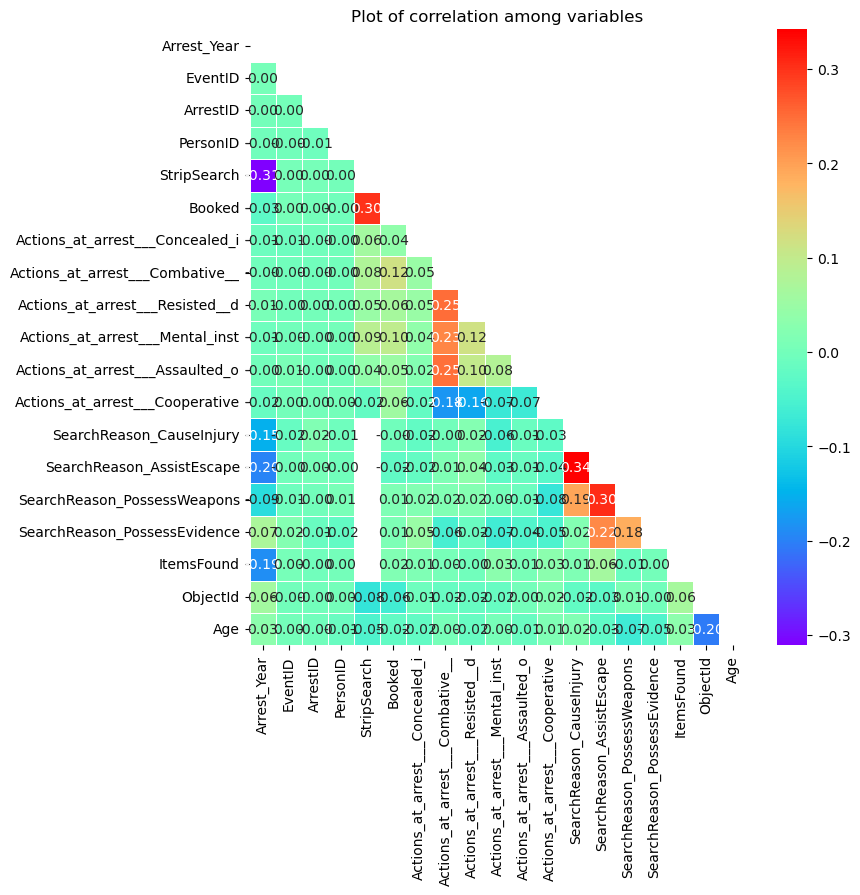

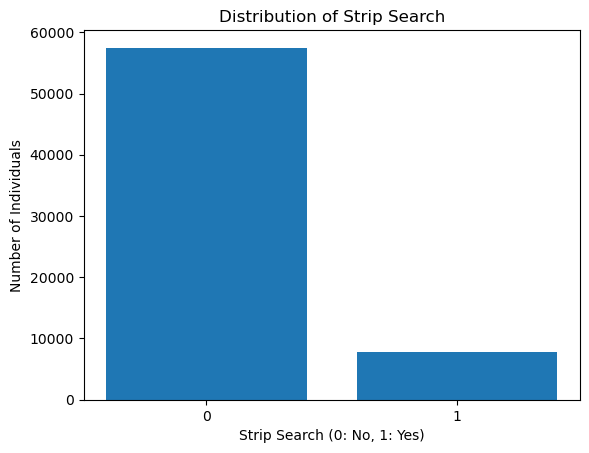

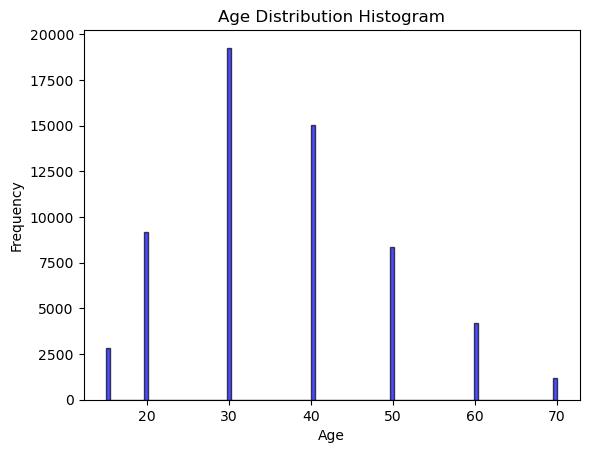

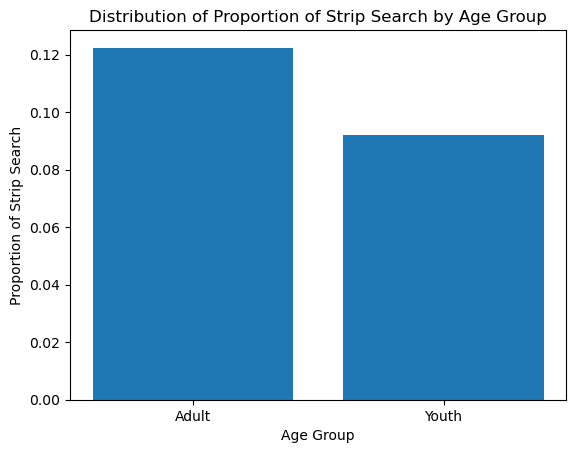

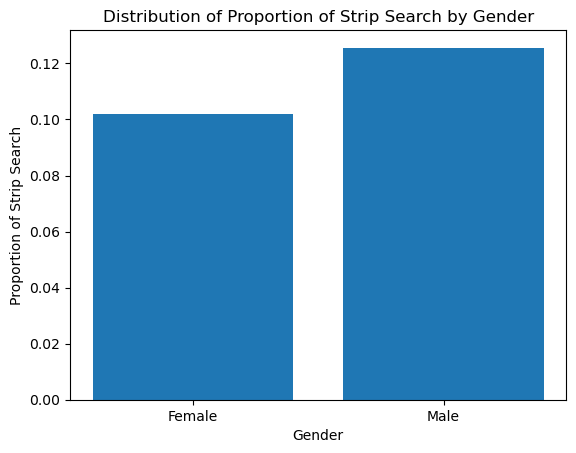

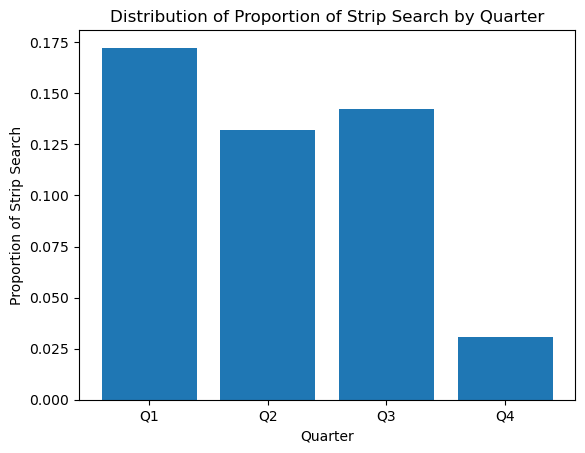

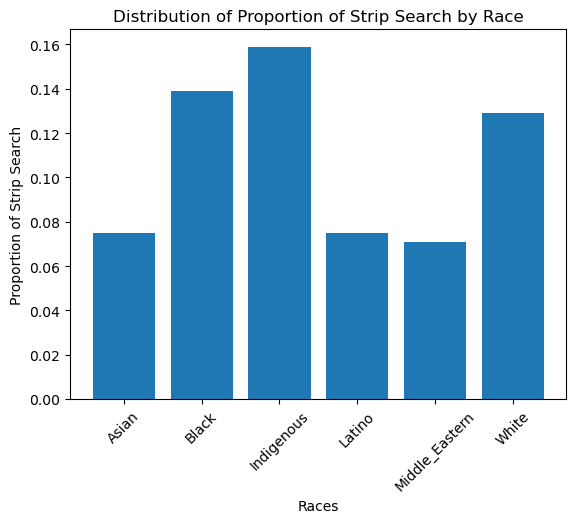

In [12]:
# Data Visualization
# Check the collinearity among each variable
corr = arrest_data.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, cmap="rainbow", linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.title("Plot of correlation among variables")
plt.show()

# Calculate the number of individuals with and without strip searches
strip_search_counts = arrest_data["StripSearch"].value_counts()

# Create a bar plot of the strip search distribution
plt.bar(strip_search_counts.index, strip_search_counts.values)

# Add labels and title to the plot
plt.xlabel("Strip Search (0: No, 1: Yes)")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Strip Search")
plt.xticks(strip_search_counts.index)
plt.show()

# Create a histogram of the age distribution
plt.hist(new_df['Age'], bins='auto', color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution Histogram')
plt.show()

# Plot strip search distribution by Age group
age_group_proportions = new_df.groupby("Age_group")["StripSearch"].mean()
plt.bar(age_group_proportions.index, age_group_proportions.values)
plt.xlabel("Age Group")
plt.ylabel("Proportion of Strip Search")
plt.title("Distribution of Proportion of Strip Search by Age Group")
plt.show()

# Plot strip search distribution by Gender
gender_proportions = new_df.groupby("Gender")["StripSearch"].mean()
plt.bar(gender_proportions.index, gender_proportions.values)
plt.xlabel("Gender")
plt.ylabel("Proportion of Strip Search")
plt.title("Distribution of Proportion of Strip Search by Gender")
plt.show()

# Plot strip search distribution by Quarter
quarter_proportions = new_df.groupby("Quarter")["StripSearch"].mean()
plt.bar(quarter_proportions.index, quarter_proportions.values)
plt.xlabel("Quarter")
plt.ylabel("Proportion of Strip Search")
plt.title("Distribution of Proportion of Strip Search by Quarter")
plt.show()

# Plot strip search distribution by Race
race_proportions = new_df.groupby("Race")["StripSearch"].mean()
plt.bar(race_proportions.index, race_proportions.values)
plt.xlabel("Races")
plt.ylabel("Proportion of Strip Search")
plt.title("Distribution of Proportion of Strip Search by Race")
plt.xticks(rotation=45)
plt.show()

In [13]:
# T-tests
# Test whether there is a significant difference in the proportion of strip searches between youth and adult.
# Separate strip search data for youth and adult
youth = new_df[new_df['Age_group'] == "Youth"]['StripSearch']
adult = new_df[new_df['Age_group'] == "Adult"]['StripSearch']

# Perform the independent two-sample t-test
t_stat, p_value = stats.ttest_ind(youth, adult)

print("t-statistic:", t_stat)
print("p-value:", p_value)

# Test whether there is a significant difference in the proportion of strip searches between males and females
# Separate strip search data for males and females
males = new_df[new_df['Gender'] == 'Male']['StripSearch']
females = new_df[new_df['Gender'] == 'Female']['StripSearch']

# Perform the independent two-sample t-test
t_stat, p_value = stats.ttest_ind(males, females)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -4.832269313385101
p-value: 1.3531816105700765e-06
t-statistic: 7.059300883623014
p-value: 1.6915062996716018e-12


In [15]:
# Perform the train-test split
X = new_df.drop('StripSearch', axis=1)
y = new_df['StripSearch']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Combine the train predictors and responses into one DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

In [16]:
# Ancova
# Fit the ANCOVA model
model = smf.ols("StripSearch ~ C(Race) + Age", data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

               sum_sq       df           F        PR(>F)
C(Race)     39.427216      5.0   74.742281  2.422474e-78
Age         12.817266      1.0  121.488635  3.179393e-28
Residual  6332.849412  60026.0         NaN           NaN


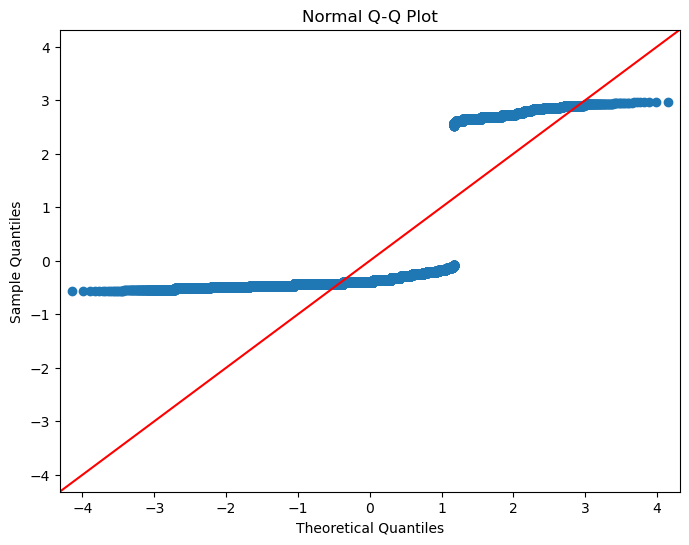

In [17]:
# Draw the Normal Q-Q plot
# Calculate residuals
residuals = model.resid
fitted_values = model.fittedvalues
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True, ax=ax)
plt.title("Normal Q-Q Plot")
plt.show()

0.006187304455103832
Required number of observations: 205025


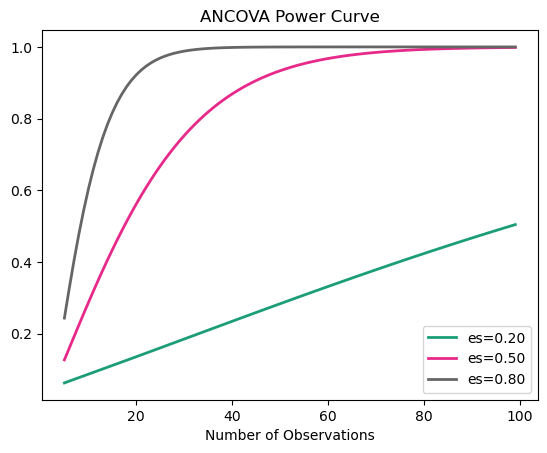

In [18]:
# Power analysis
effect_size = partial_eta_squared(anova_table)
print(effect_size)
alpha = 0.05  # 5% significance level
power = 0.8  # 80% power
analysis = smp.FTestAnovaPower()
required_nobs = analysis.solve_power(effect_size=effect_size, nobs=None, alpha=alpha, power=power)
print("Required number of observations:", round(required_nobs))
# Define parameters for the power curve
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))
# Initialize power object for ANCOVA
anova_power = FTestAnovaPower()
# Calculate power for ANCOVA
anova_powers = anova_power.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes,
                                          title='ANCOVA Power Curve')
# Show the power curve
plt.show()

In [21]:
# Logistic Regression Model
# Create the formula string
formula = "StripSearch ~ Race + Age_group + Quarter + Gender"
print("Formula: ", formula, "\n")

# Put the training predictors and responses into one DataFrame to be input into the model
trainingdata = pd.concat([X_train, y_train], axis=1)

# Build the model
log_reg_1 = smf.logit(formula, data=trainingdata).fit()
print(log_reg_1.summary())

# Getting odds ratios
odds_ratios = np.exp(log_reg_1.params)

# Calculate confidence intervals
conf = log_reg_1.conf_int()
conf['OR'] = odds_ratios
conf.columns = ['Lower CI', 'Upper CI', 'OR']

# Displaying the exponentiated confidence intervals
print(np.exp(conf))

# Predict responses
pred_1 = log_reg_1.predict(X_test)
# round() rounds to the nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_1 = list(map(round, pred_1))

# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))

Formula:  StripSearch ~ Race + Age_group + Quarter + Gender 

Optimization terminated successfully.
         Current function value: 0.347452
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            StripSearch   No. Observations:                48026
Model:                          Logit   Df Residuals:                    48015
Method:                           MLE   Df Model:                           10
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.05455
Time:                        04:18:29   Log-Likelihood:                -16687.
converged:                       True   LL-Null:                       -17650.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept             

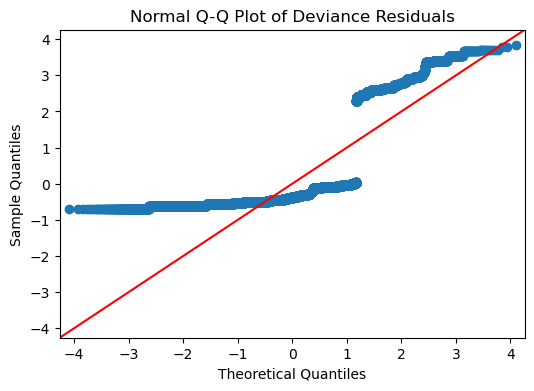

In [20]:
# Draw the Normal Q-Q plot
# Calculate deviance residuals
residuals = log_reg_1.resid_dev
fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.qqplot(residuals, line='45', fit=True, ax=ax)
ax.set_title("Normal Q-Q Plot of Deviance Residuals")
plt.show()

Intercept                -1.261664
Race[T.Black]             0.375201
Race[T.Indigenous]        0.481423
Race[T.Latino]           -0.008145
Race[T.Middle_Eastern]   -0.049342
Race[T.White]             0.313174
Age_group[T.Youth]       -0.225025
Quarter[T.Q2]            -0.183374
Quarter[T.Q3]            -0.124511
Quarter[T.Q4]            -1.031045
Gender[T.Male]            0.149622
dtype: float64
Required sample size: 236647


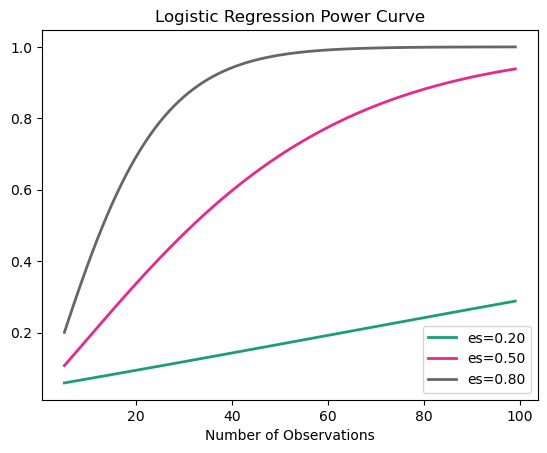

In [22]:
# Power analysis
# Calculate odds ratios
odds_ratios = np.exp(log_reg_1.params)
# Convert odds ratios to Cohen's d effect sizes
effect_sizes = np.log(odds_ratios) * np.sqrt(3) / np.pi
print(effect_sizes)
# Define power and significance level
power = 0.8
alpha = 0.05
# Find the minimum effect size among the predictors
min_effect_size = np.min(np.abs(effect_sizes[1:]))
# Conduct power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=min_effect_size, power=power, alpha=alpha, ratio=1,
                                    alternative='two-sided')
print("Required sample size:", round(sample_size))
# Define parameters for the power curve
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))

# Initialize power object for logistic regression
logit_power = TTestIndPower()

# Calculate power for logistic regression
logit_powers = logit_power.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes,
                                        title='Logistic Regression Power Curve')

# Show the Power Curve
plt.show()

In [23]:
# Prediction interval
# Get the prediction summary frame for the test data
test_data = pd.concat([X_test, y_test], axis=1)
prediction_summary = model.get_prediction(sm.add_constant(X_test)).summary_frame(alpha=0.05)

# Reset the index of y_test and the prediction summary DataFrame
y_test = y_test.reset_index(drop=True)
prediction_summary = prediction_summary.reset_index(drop=True)

# Calculate the percentage of target values in the test data that fall within the prediction intervals
within_interval = y_test.between(prediction_summary['obs_ci_lower'], prediction_summary['obs_ci_upper']).mean()
print(f"{within_interval:.2%} of the prediction intervals contain true target.")

87.62% of the prediction intervals contain true target.
